In [1]:
import torch
import scanpy as sc

from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import os
from sklearn.decomposition import PCA
from scvi.model import SCVI
from scripts import constants
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import sem

Global seed set to 0


In [2]:
dataset = "haber_2017"

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    )
)

target_adata = adata[adata.obs["condition"] != "Control"].copy()
background_adata = adata[adata.obs["condition"] == "Control"].copy()

target_trans_adata = target_adata.copy()
background_trans_adata = background_adata.copy()

SCVI.setup_anndata(target_adata, layer="count")
SCVI.setup_anndata(target_trans_adata)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Successfully registered anndata object containing 4481 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 4

In [4]:
seeds = [123, 42, 789, 46, 999]
latent_size = 10

learned_lib_contrastive_vi_latent_representations = [
    np.load(
        os.path.join(
            "/projects/leelab/contrastiveVI/results-learned-lib-size",
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

learned_lib_sc_vi_latent_representations = [
    np.load(
        os.path.join(
            "/projects/leelab/contrastiveVI/results-learned-lib-size",
            f"{dataset}/scVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

cplvm_latent_representations = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/CPLVM/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

cglvm_latent_representations = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/CGLVM/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 196.08it/s]


In [5]:
salient_representation_dict = {
    "scVI": learned_lib_sc_vi_latent_representations,
    "CPLVM": cplvm_latent_representations,
    "CGLVM": cglvm_latent_representations,
    "contrastiveVI": learned_lib_contrastive_vi_latent_representations,
}

In [6]:
labels = target_adata.obs["condition"]
one_hot_labels = LabelEncoder().fit_transform(labels)

silhouette_results_dict = {}
ari_results_dict = {}
nmi_results_dict = {}
for model_name, latent_list in salient_representation_dict.items():
    print(f"Evaluating {model_name} representations...")
    silhouette_results = []
    ari_results = []
    nmi_results = []
    
    for latent in tqdm(latent_list):
        latent_clustering = KMeans(n_clusters=2, random_state=123).fit(latent).labels_
        silhouette_results.append(silhouette_score(latent, one_hot_labels))
        ari_results.append(adjusted_rand_score(one_hot_labels, latent_clustering))
        nmi_results.append(adjusted_mutual_info_score(one_hot_labels, latent_clustering))
        
    silhouette_results_dict[model_name] = silhouette_results
    ari_results_dict[model_name] = ari_results
    nmi_results_dict[model_name] = nmi_results
    
print("Done!")

Evaluating scVI representations...


100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]


Evaluating CPLVM representations...


100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.01s/it]


Evaluating CGLVM representations...


100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.16s/it]


Evaluating contrastiveVI representations...


100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.13s/it]

Done!


In [7]:
from umap import UMAP

salient_two_dim_dict = {
    "scVI" : learned_lib_sc_vi_latent_representations[0],
    "contrastiveVI": learned_lib_contrastive_vi_latent_representations[0],
}
xlabel = "latent 1"
ylabel = "latent 2"
if latent_size > 2:
    for key, rep in salient_two_dim_dict.items():
        salient_two_dim_dict[key] = UMAP().fit_transform(rep)[:, :2]
    xlabel = "UMAP1"
    ylabel = "UMAP2"

In [8]:
seed = 123
contrastiveVI_models = [torch.load(
    os.path.join(
        "/projects/leelab/contrastiveVI/results-learned-lib-size",
        f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}/model.ckpt",
    )
) for seed in seeds]
contrastiveVI_background_representations = [model.get_latent_representation(
    adata=target_adata, representation_kind="background") for model in contrastiveVI_models]

cplvm_models = [pickle.load(open(
    os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/CPLVM/latent_{latent_size}/{seed}/model.pkl",
    ), "rb"),
) for seed in seeds]
cplvm_background_representations = [model["qzy_mean"] for model in cplvm_models]

cglvm_models = [pickle.load(open(
    os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/CGLVM/latent_{latent_size}/{seed}/model.pkl",
    ), "rb"),
) for seed in seeds]
cglvm_background_representations = [model["qzy_mean"] for model in cglvm_models]

background_representation_dict = {
    "contrastiveVI": contrastiveVI_background_representations,
    "CPLVM": cplvm_background_representations,
    "CGLVM": cglvm_background_representations,
    "scVI": learned_lib_sc_vi_latent_representations
}

background_two_dim = UMAP().fit_transform(contrastiveVI_background_representations[0])[:, :2]

During startup - Warning messages:
1: package ‘methods’ was built under R version 3.6.1 
2: package ‘datasets’ was built under R version 3.6.1 
3: package ‘utils’ was built under R version 3.6.1 
4: package ‘grDevices’ was built under R version 3.6.1 
5: package ‘graphics’ was built under R version 3.6.1 
6: package ‘stats’ was built under R version 3.6.1 


In [9]:
labels = target_adata.obs["cell_type"]
one_hot_labels = LabelEncoder().fit_transform(labels)

bg_silhouette_results_dict = {}
bg_ari_results_dict = {}
bg_nmi_results_dict = {}
for model_name, latent_list in background_representation_dict.items():
    print(f"Evaluating {model_name} representations...")
    silhouette_results = []
    ari_results = []
    nmi_results = []
    
    for latent in tqdm(latent_list):
        latent_clustering = KMeans(n_clusters=len(np.unique(target_adata.obs["cell_type"])), random_state=123).fit(latent).labels_
        silhouette_results.append(silhouette_score(latent, one_hot_labels))
        ari_results.append(adjusted_rand_score(one_hot_labels, latent_clustering))
        nmi_results.append(adjusted_mutual_info_score(one_hot_labels, latent_clustering))
        
    bg_silhouette_results_dict[model_name] = silhouette_results
    bg_ari_results_dict[model_name] = ari_results
    bg_nmi_results_dict[model_name] = nmi_results
    
print("Done!")

Evaluating contrastiveVI representations...


100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


Evaluating CPLVM representations...


100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it]


Evaluating CGLVM representations...


100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


Evaluating scVI representations...


100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]

Done!


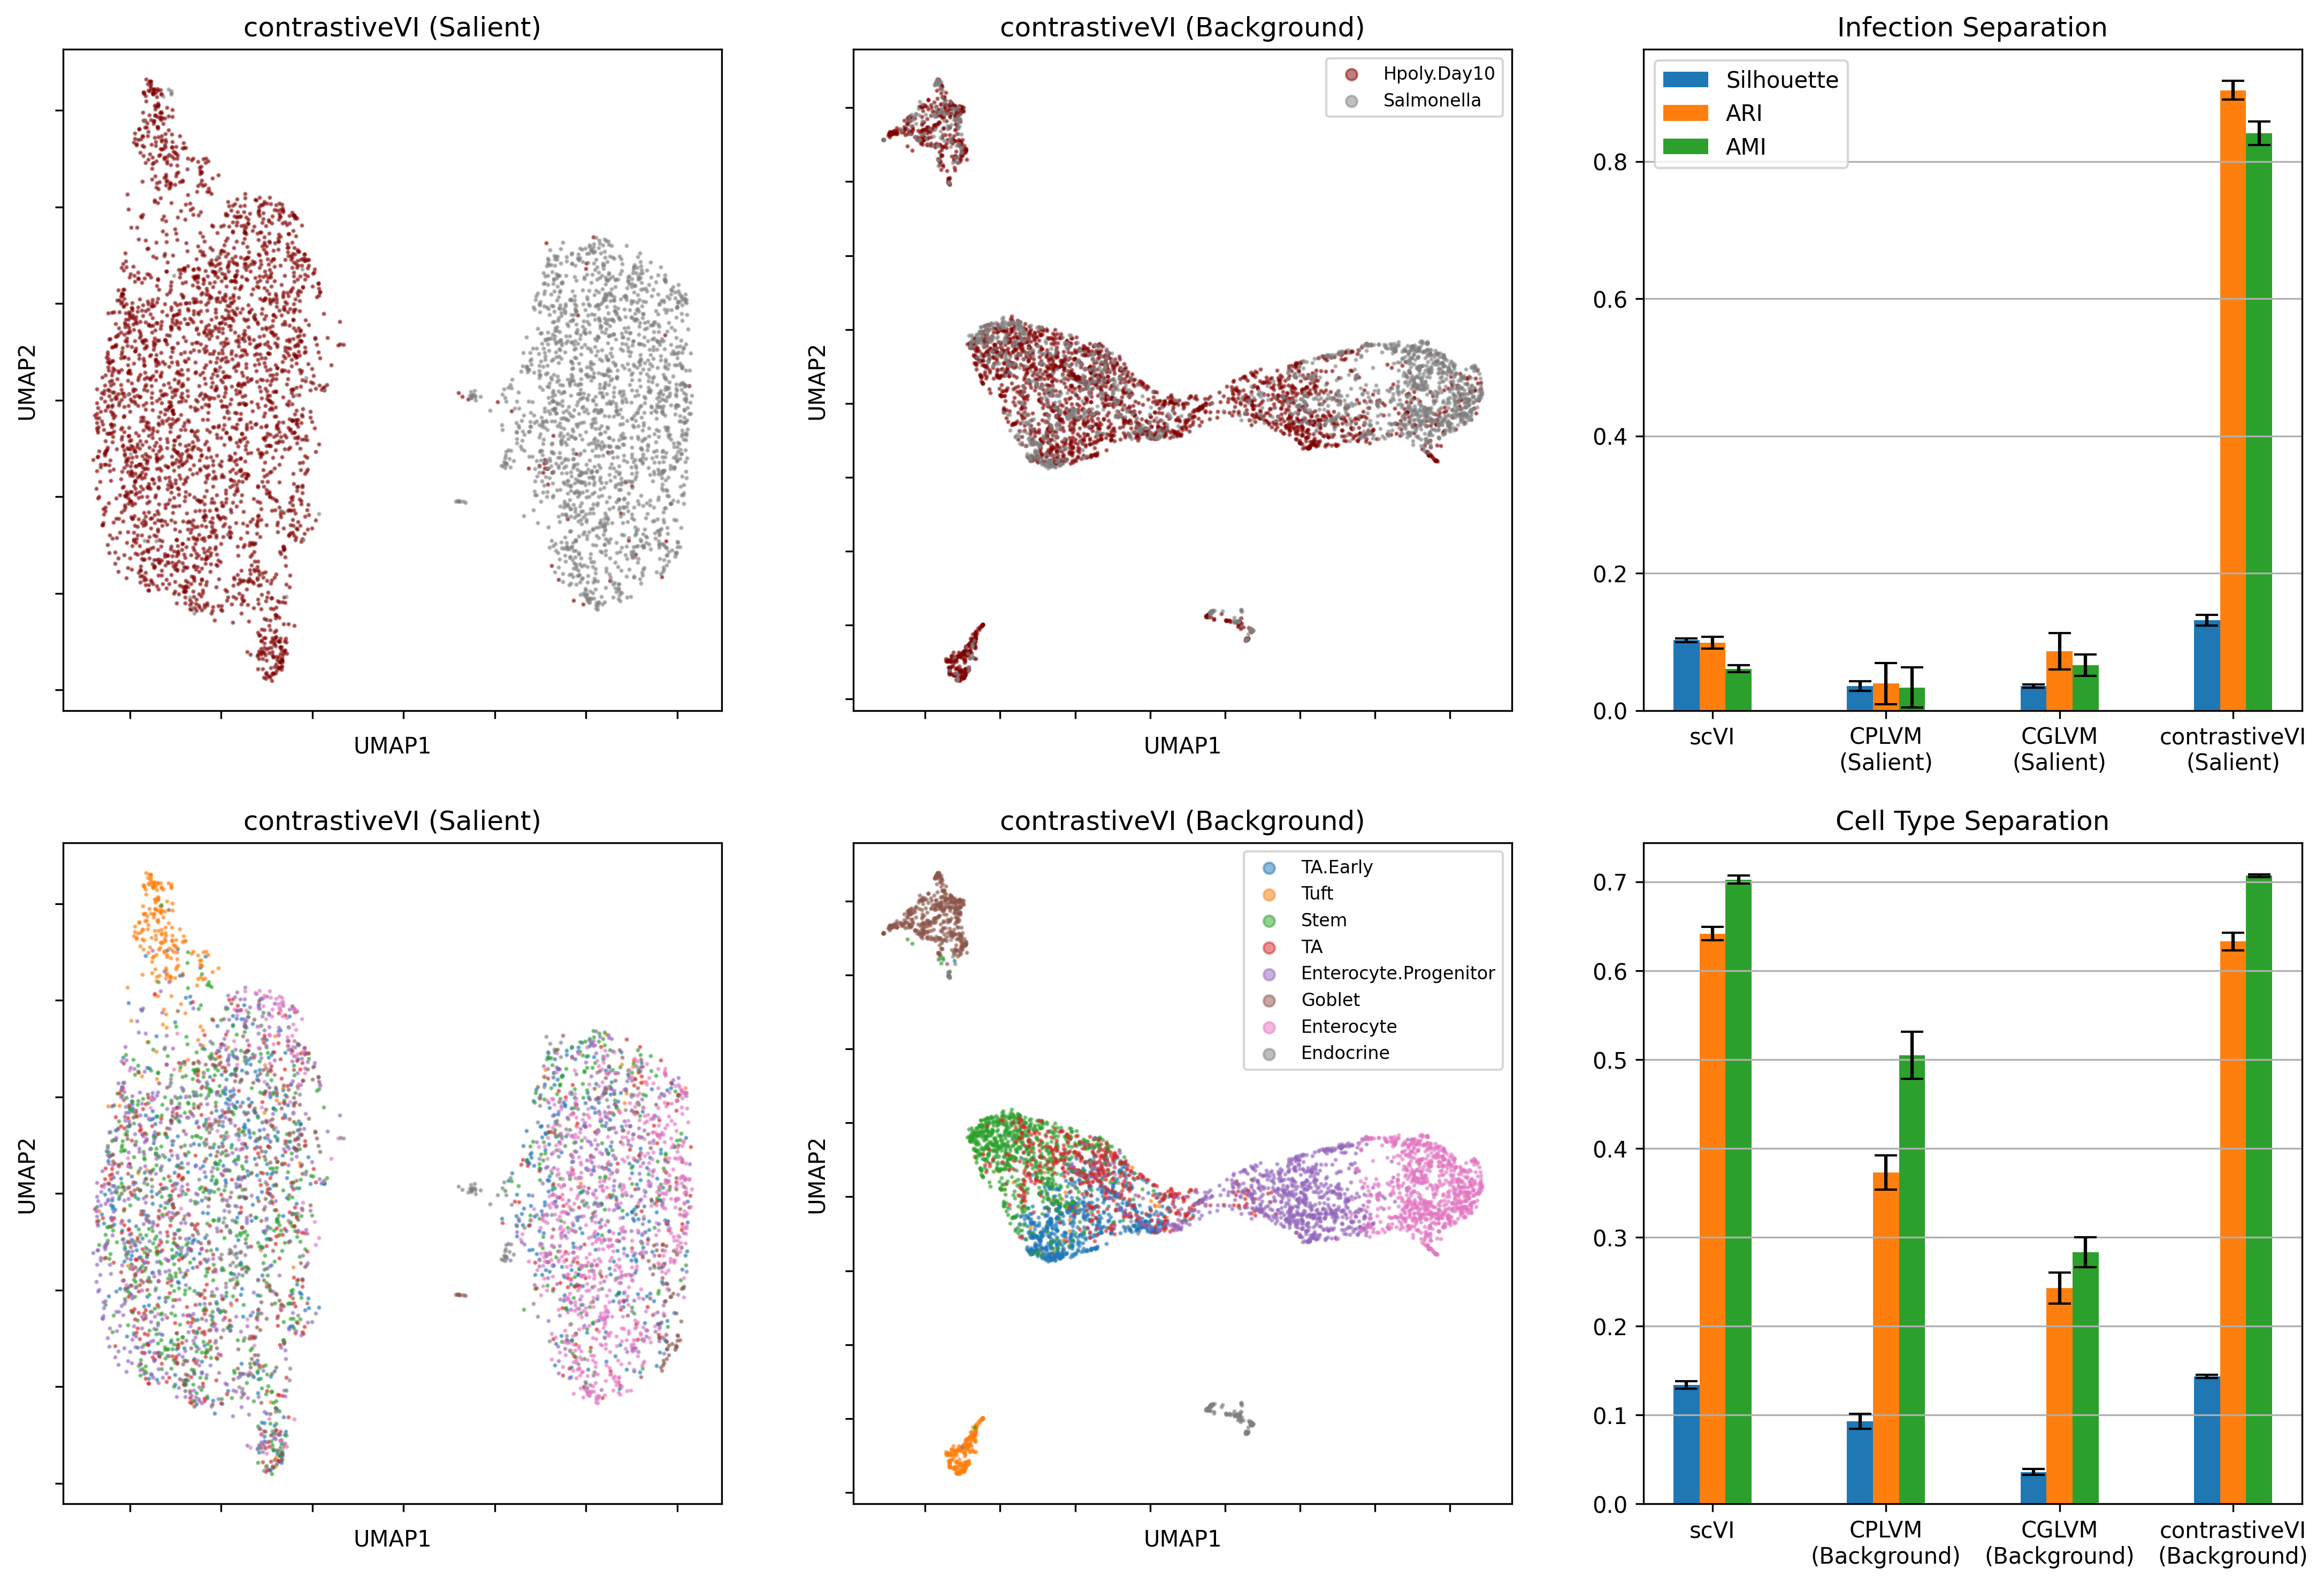

In [13]:
import copy

model_labels = [model_name for model_name in salient_representation_dict.keys()]
width = 0.15  # Bar width
x = np.arange(len(model_labels))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
capsize=5

target_labels = target_adata.obs["condition"]
rep = salient_two_dim_dict['contrastiveVI']
colors = ["maroon", "gray"]
for i, label in enumerate(target_labels.unique()):
    ax1.scatter(
        rep[:, 0][target_labels == label],
        rep[:, 1][target_labels == label],
        s=1,
        label=label,
        color=colors[i],
        alpha=0.5,
    )
ax1.set_title("contrastiveVI (Salient)")
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")

cell_type_labels = target_adata.obs["cell_type"]
ax2.set_title("contrastiveVI (Background)")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
rep = background_two_dim
for i, label in enumerate(target_labels.unique()):
    ax2.scatter(
        rep[:, 0][target_labels == label],
        rep[:, 1][target_labels == label],
        s=1,
        label=label,
        color=colors[i],
        alpha=0.5,
    )
ax2.legend(markerscale=5, fontsize=8)
ax2.set_xlabel("UMAP1")
ax2.set_ylabel("UMAP2")

ax3.bar(
    x,
    [np.mean(silhouette_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(silhouette_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="Silhouette",
)
ax3.bar(
    x + width,
    [np.mean(ari_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(ari_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="ARI",
)
ax3.bar(
    x + width * 2,
    [np.mean(nmi_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(nmi_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="AMI",
)

ax3.set_xticks(x + width)
infection_model_labels = copy.deepcopy(model_labels)
infection_model_labels[-1] += "\n(Salient)"
infection_model_labels[-2] += "\n(Salient)"
infection_model_labels[-3] += "\n(Salient)"
ax3.set_xticklabels(infection_model_labels)
ax3.grid(axis='y')
ax3.legend()
ax3.set_title("Infection Separation")

rep = salient_two_dim_dict['contrastiveVI']
for i, label in enumerate(cell_type_labels.unique()):
    ax4.scatter(
        rep[:, 0][cell_type_labels == label],
        rep[:, 1][cell_type_labels == label],
        s=1,
        label=label,
        alpha=0.5,
    )
ax4.set_title("contrastiveVI (Salient)")
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.set_xlabel("UMAP1")
ax4.set_ylabel("UMAP2")

ax5.set_title("contrastiveVI (Background)")
ax5.set_xticklabels([])
ax5.set_yticklabels([])
rep = background_two_dim
for i, label in enumerate(cell_type_labels.unique()):
    ax5.scatter(
        rep[:, 0][cell_type_labels == label],
        rep[:, 1][cell_type_labels == label],
        s=1,
        label=label,
        alpha=0.5,
    )
ax5.legend(markerscale=5, fontsize=8, loc='upper right')
ax5.set_xlabel("UMAP1")
ax5.set_ylabel("UMAP2")

ax6.bar(
    x,
    [np.mean(bg_silhouette_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(bg_silhouette_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="Silhouette",
)
ax6.bar(
    x + width,
    [np.mean(bg_ari_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(bg_ari_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="ARI",
)
ax6.bar(
    x + width * 2,
    [np.mean(bg_nmi_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(bg_nmi_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="AMI",
)
cell_type_model_labels = copy.deepcopy(model_labels)
cell_type_model_labels[-1] += "\n(Background)"
cell_type_model_labels[-2] += "\n(Background)"
cell_type_model_labels[-3] += "\n(Background)"
ax6.grid(axis='y')
ax6.set_xticks(x + width)
ax6.set_xticklabels(cell_type_model_labels)
ax6.set_title("Cell Type Separation")
plt.gcf().set_dpi(300)
plt.show()